In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math
from math import sqrt, gcd
import os

In [2]:
# ============================================================
# Tight-binding parameters (energies in eV, distances in Å)
# ============================================================
r0 = 1.42
Vss_sigma = -6.8
Vsp_sigma =  6.0
Vpp_sigma =  6.4
Vpp_pi    = -2.7

Vss_sigma_overlap = -0.2
Vsp_sigma_overlap =  0.1
Vpp_sigma_overlap =  0.2
Vpp_pi_overlap    = -0.05

Nk = 500            # number of k-points
s_floor    = 1e-6           # overlap matrix floor (for Lowdin orthogonalization)
sqrt3 = np.sqrt(3.0)
a_lat = sqrt3 * r0
r_cut = 1.42  # Cutoff distance for neighbor interactions
# Plot settings
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['DejaVu Serif', 'Times New Roman', 'serif'],
    'mathtext.fontset': 'cm',  # Computer Modern math fonts
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
})


unique positions = 40
theoretical number of atom = 40
Computed Band Gap (global) : 0.010008 eV


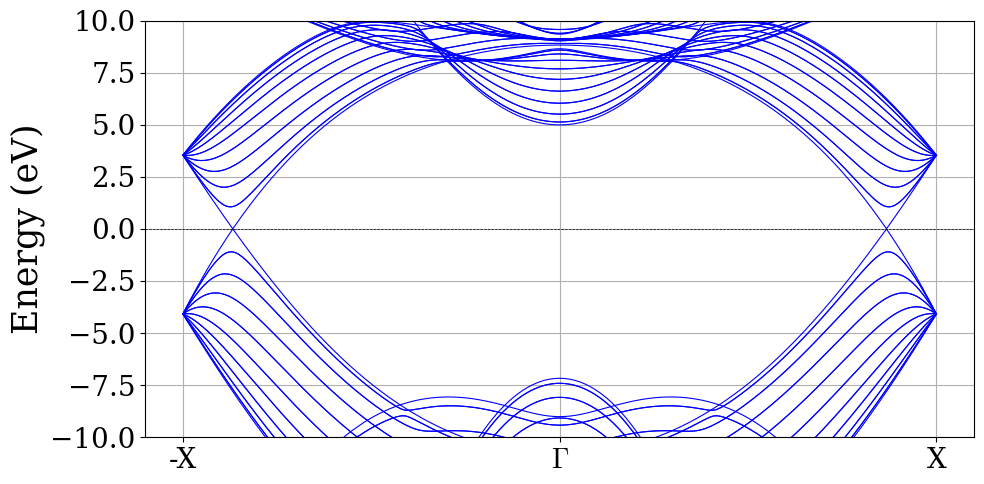

In [ ]:
def compute_Ch(n: int, m: int):
    """
    Compute the chiral vector C_h, the translational vector T, and the number of
    atoms in the CNT primitive cell for a general chirality (n, m).

    Parameters
    ----------
    n, m : int
        Nanotube chiral indices.

    Returns
    -------
    (Ch_vec, T_vec, N_atom_cell, a1, a2) : tuple
        Ch_vec : np.ndarray shape (2,)
            2D chiral vector C_h = n a1 + m a2 (Å).
        T_vec : np.ndarray shape (2,)
            2D translational vector T = T1 a1 + T2 a2 (Å).
        N_atom_cell : int
            Number of carbon atoms in the CNT primitive cell.
        a1, a2 : np.ndarray shape (2,)
            Graphene primitive vectors (Å).

    Notes
    -----
    - a1, a2 are constructed as:
        a1 = r0 * (√3/2,  1/2), a2 = r0 * (√3/2, −1/2).
      If you use r0 = 2.46 Å (graphene lattice constant), these are standard.
      If r0 is the C–C bond length (~1.42 Å), replace r0 with a_graphene = √3*r0.
    """
    sqrt3 = np.sqrt(3)
    a1 = r0 * np.array([sqrt3/2,  1/2])   # graphene primitive vector #1 (Å)
    a2 = r0 * np.array([sqrt3/2, -1/2])   # graphene primitive vector #2 (Å)
    Ch_vec = n * a1 + m * a2              # C_h = n a1 + m a2

    # Translational vector T = T1 a1 + T2 a2 with the standard gcd rule
    d = gcd(2*n + m, 2*m + n)
    T1 = (2*m + n) // d
    T2 = -(2*n + m) // d
    T_vec = T1 * a1 + T2 * a2

    # Number of atoms in the CNT primitive cell
    N_atom_cell = 4 * (n**2 + m**2 + n*m) // d
    return Ch_vec, T_vec, N_atom_cell, a1, a2


def generate_CNT_lattice(n: int, m: int, include_B: bool = True, eps: float = 1e-6):
    """
    Generate unique 2D atomic coordinates within the CNT primitive cell by
    rolling a graphene sheet (general (n, m), not restricted to armchair).

    Parameters
    ----------
    n, m : int
        Nanotube chiral indices.
    include_B : bool, default True
        If True, include the B sublattice; otherwise only A sublattice.
    eps : float, default 1e-6
        Tolerance to fold boundary points back into the unit cell.

    Returns
    -------
    (unique_positions, None, Ch_vec, T_vec) : tuple
        unique_positions : (N_atom_cell, 2) np.ndarray
            2D positions folded into the [C_h, T] parallelogram cell (Å).
        None : placeholder
            Reserved for sublattice labels if needed later.
        Ch_vec, T_vec : np.ndarray shape (2,)
            Chiral and translational vectors (Å).

    Raises
    ------
    AssertionError
        If the number of unique positions does not match the theoretical count.

    Notes
    -----
    - The search window size L is chosen heuristically from |C_h|/r0 + margin.
    - B sublattice is placed at (a1+a2)/3 w.r.t. A.
    """
    Ch_vec, T_vec, N_theoretical, a1, a2 = compute_Ch(n, m)
    M = np.column_stack((Ch_vec, T_vec))   # columns = [C_h, T]
    invM = np.linalg.inv(M)

    # Heuristic search window for lattice points (A and optional B)
    L = int(np.ceil(np.linalg.norm(Ch_vec) / r0)) + 10
    positions = []

    for t1 in range(-L, L+1):
        for t2 in range(-L, L+1):
            # A sublattice candidate
            pos_A = t1 * a1 + t2 * a2
            frac = invM.dot(pos_A)
            if (0 <= frac[0] < 1) and (0 <= frac[1] < 1):
                frac_mod = frac - np.floor(frac)
                frac_mod = np.where(frac_mod >= 1 - eps, 0, frac_mod)  # fold edges
                pos_folded = np.round(M.dot(frac_mod), decimals=6)
                positions.append(pos_folded)

            # Optional B sublattice candidate
            if include_B:
                pos_B = pos_A + (a1 + a2) / 3
                fracB = invM.dot(pos_B)
                if (0 <= fracB[0] < 1) and (0 <= fracB[1] < 1):
                    fracB_mod = fracB - np.floor(fracB)
                    fracB_mod = np.where(fracB_mod >= 1 - eps, 0, fracB_mod)
                    pos_B_folded = np.round(M.dot(fracB_mod), decimals=6)
                    positions.append(pos_B_folded)

    positions = np.array(positions)
    unique_positions = np.unique(positions, axis=0)

    assert len(unique_positions) == N_theoretical, \
        "Number of atoms does not match theoretical value"
    print(f'unique positions = {len(unique_positions)}')
    print(f'theoretical number of atom = {N_theoretical}')
    return unique_positions, None, Ch_vec, T_vec


def get_3d_pos(th: float, z: float, R: float):
    """
    Map cylindrical coordinates to Cartesian coordinates on the CNT surface.

    Parameters
    ----------
    th : float
        Azimuthal angle θ (radians) around the tube.
    z : float
        Axial coordinate along T (Å).
    R : float
        Tube radius (Å).

    Returns
    -------
    (x, y, z) : tuple of floats
        Cartesian position (Å).
    """
    x = R * np.cos(th)
    y = R * np.sin(th)
    return x, y, z


def get_3d_vec(i: int, j: int, tharr: np.ndarray, zarr: np.ndarray, R: float, shift_z: float = 0.0):
    """
    Vector from atom i to atom j on the CNT surface (optionally shifted by ±T
    for inter-cell neighbors).

    Parameters
    ----------
    i, j : int
        Atom indices within the primitive cell.
    tharr, zarr : np.ndarray
        Arrays of θ and z for each atom in the cell.
    R : float
        Tube radius (Å).
    shift_z : float, default 0.0
        Additive axial shift (Å) to connect to neighbor in an adjacent cell.

    Returns
    -------
    (rx, ry, rz) : tuple of floats
        3D vector components (Å).
    """
    x1, y1, z1 = get_3d_pos(tharr[i], zarr[i], R)
    x2, y2, z2 = get_3d_pos(tharr[j], zarr[j] + shift_z, R)
    return (x2 - x1, y2 - y1, z2 - z1)


def cylindrical_direction(rx: float, ry: float, rz: float):
    """
    Direction cosines (l, m, n) and distance for a 3D interatomic vector.

    Parameters
    ----------
    rx, ry, rz : float
        Cartesian vector components (Å).

    Returns
    -------
    (l, m, n, dist) : tuple
        l, m : float
            Direction cosines within the cylindrical plane.
        n : float
            Direction cosine along the tube axis.
        dist : float
            Vector magnitude (Å).
    """
    r_cyl = np.hypot(rx, ry)
    if r_cyl < 1e-8:
        return 0, 0, 0, 0
    l = rx / r_cyl
    m = ry / r_cyl
    dist = np.sqrt(rx*rx + ry*ry + rz*rz)
    if abs(dist) < 1e-12:
        return 0, 0, 0, dist
    n = rz / dist
    return l, m, n, dist


def sk_matrix(rx: float, ry: float, rz: float, is_first_nn: bool = True):
    """
    4×4 Slater–Koster Hamiltonian/overlap sub-blocks between two atoms with
    interatomic vector (rx, ry, rz).

    Parameters
    ----------
    rx, ry, rz : float
        Vector components (Å).
    is_first_nn : bool, default True
        Tag kept for future use (e.g., different parameter sets by shell).

    Returns
    -------
    (H_block, S_block) : tuple of np.ndarray
        4×4 blocks in the (s, p_x, p_y, p_z) basis.

    Notes
    -----
    - Distance-dependent matrix elements: V(dist) = V0 * exp(-β (dist/r0 - 1))
      (same form for overlap with β_overlap). Ensure r0 matches the reference
      bond length used to fit your SK parameters.
    """
    l, m, n, dist = cylindrical_direction(rx, ry, rz)
    if dist < 1e-12:
        return np.zeros((4, 4), dtype=complex), np.eye(4)

    # Distance-dependent hoppings (energy) and overlaps (dimensionless)
    vsig = Vpp_sigma * np.exp(-beta * ((dist / r0) - 1))
    vpi  = Vpp_pi    * np.exp(-beta * ((dist / r0) - 1))
    vsp  = Vsp_sigma * np.exp(-beta * ((dist / r0) - 1))
    vss  = Vss_sigma * np.exp(-beta * ((dist / r0) - 1))

    s_vsig = Vpp_sigma_overlap * np.exp(-beta_overlap * ((dist / r0) - 1))
    s_vpi  = Vpp_pi_overlap    * np.exp(-beta_overlap * ((dist / r0) - 1))
    s_vsp  = Vsp_sigma_overlap * np.exp(-beta_overlap * ((dist / r0) - 1))
    s_vss  = Vss_sigma_overlap * np.exp(-beta_overlap * ((dist / r0) - 1))

    H_block = np.zeros((4, 4), dtype=complex)
    S_block = np.zeros((4, 4), dtype=complex)

    # Hamiltonian entries (s, px, py, pz)
    H_block[0, 0] = vss
    H_block[0, 1] =  l * vsp
    H_block[0, 2] =  m * vsp
    H_block[0, 3] =  n * vsp

    H_block[1, 0] = -l * vsp
    H_block[2, 0] = -m * vsp
    H_block[3, 0] = -n * vsp

    H_block[1, 1] = (l*l)*vsig + (1 - l*l)*vpi
    H_block[2, 2] = (m*m)*vsig + (1 - m*m)*vpi
    H_block[3, 3] = (n*n)*vsig + (1 - n*n)*vpi
    H_block[1, 2] = H_block[2, 1] = l*m*(vsig - vpi)
    H_block[1, 3] = H_block[3, 1] = l*n*(vsig - vpi)
    H_block[2, 3] = H_block[3, 2] = m*n*(vsig - vpi)

    # Overlap entries (dimensionless)
    S_block[0, 0] = s_vss
    S_block[0, 1] =  l * s_vsp
    S_block[0, 2] =  m * s_vsp
    S_block[0, 3] =  n * s_vsp

    S_block[1, 0] = -l * s_vsp
    S_block[2, 0] = -m * s_vsp
    S_block[3, 0] = -n * s_vsp

    S_block[1, 1] = (l*l)*s_vsig + (1 - l*l)*s_vpi
    S_block[2, 2] = (m*m)*s_vsig + (1 - m*m)*s_vpi
    S_block[3, 3] = (n*n)*s_vsig + (1 - n*n)*s_vpi
    S_block[1, 2] = S_block[2, 1] = l*m*(s_vsig - s_vpi)
    S_block[1, 3] = S_block[3, 1] = l*n*(s_vsig - s_vpi)
    S_block[2, 3] = S_block[3, 2] = m*n*(s_vsig - s_vpi)

    return H_block, S_block


def build_hamiltonian(n: int, m: int):
    """
    Assemble a callable builder H_of_k(k) that returns (H(k), S(k)) for a CNT.

    Parameters
    ----------
    n, m : int
        Chiral indices.

    Returns
    -------
    (H_of_k, info) : tuple
        H_of_k : callable
            Function k -> (H(k), S(k)).
        info : dict
            'theta_list' : np.ndarray of θ per atom
            'z_list'     : np.ndarray of z per atom (Å)
            'R'          : radius (Å)
            'T_length'   : |T|, the unit-cell length along the tube (Å)
            'N_cell'     : number of atoms in the primitive cell
            'Ch_vec'     : 2D chiral vector (Å)
    """
    coords_2D, _subl, Ch_vec, T_vec = generate_CNT_lattice(n, m, True)
    N_cell = len(coords_2D)

    # Geometry
    R = (2.46 / (2*np.pi)) * math.sqrt(n*n + n*m + m*m)      # tube radius (Å)
    T_length = np.linalg.norm(T_vec)                          # unit cell length (Å)

    # Unit vectors along chiral and translational directions
    hatC = Ch_vec / np.linalg.norm(Ch_vec)
    hatT = T_vec / np.linalg.norm(T_vec)

    # Map 2D positions into cylindrical coordinates (θ, z)
    tharr, zarr = [], []
    for rr in coords_2D:
        th = (2*math.pi / np.linalg.norm(Ch_vec)) * (rr.dot(hatC))
        zz = rr.dot(hatT)
        tharr.append(th)
        zarr.append(zz)
    tharr = np.array(tharr)
    zarr  = np.array(zarr)

    # Collect first-nearest neighbors inside the cell
    nb_in = []
    for i in range(N_cell):
        for j in range(i+1, N_cell):
            rx, ry, rz = get_3d_vec(i, j, tharr, zarr, R)
            dd = np.sqrt(rx**2 + ry**2 + rz**2)
            if dd < r_cut:
                nb_in.append((i, j))

    # Collect first-nearest neighbors across ±1 unit cell along T
    nb_int = []
    for i in range(N_cell):
        for j in range(N_cell):
            rx, ry, rz = get_3d_vec(i, j, tharr, zarr, R, shift_z=T_length)
            dd = np.sqrt(rx**2 + ry**2 + rz**2)
            if dd < r_cut:
                nb_int.append((i, j, T_length))

    def place_block(H: np.ndarray, S: np.ndarray, i4: int, j4: int,
                    subH: np.ndarray, subS: np.ndarray):
        """Place a 4×4 block and its Hermitian counterpart."""
        H[i4:i4+4, j4:j4+4] += subH
        H[j4:j4+4, i4:i4+4] += subH.T
        S[i4:i4+4, j4:j4+4] += subS
        S[j4:j4+4, i4:i4+4] += subS.T

    def H_of_k(kpar: float):
        """
        Build (H(k), S(k)) at wavevector kpar (1/Å) along the tube axis.

        Notes
        -----
        - Inter-cell blocks are multiplied by the Bloch phase exp(i k Δz).
        - On-site/self blocks are assumed to be included via SK tables if desired
          (currently only off-diagonal first-neighbor terms are added here).
        """
        Hdim = 4 * N_cell
        Sdim = 4 * N_cell
        H = np.zeros((Hdim, Hdim), dtype=complex)
        S = np.zeros((Sdim, Sdim), dtype=complex)

        # Intra-cell NN blocks
        for (i, j) in nb_in:
            rx, ry, rz = get_3d_vec(i, j, tharr, zarr, R, shift_z=0.0)
            Hblock, Sblock = sk_matrix(rx, ry, rz, is_first_nn=True)
            i4, j4 = 4*i, 4*j
            place_block(H, S, i4, j4, Hblock, Sblock)

        # Inter-cell NN blocks (±T); we add the +T image with Bloch phase
        for (i, j, dz) in nb_int:
            rx, ry, rz = get_3d_vec(i, j, tharr, zarr, R, shift_z=dz)
            Hblock, Sblock = sk_matrix(rx, ry, rz, is_first_nn=True)
            phase = np.exp(1j * kpar * dz)  # Bloch factor
            i4, j4 = 4*i, 4*j
            H[i4:i4+4, j4:j4+4] += Hblock * phase
            H[j4:j4+4, i4:i4+4] += Hblock.conj().T * phase.conj()
            S[i4:i4+4, j4:j4+4] += Sblock * phase
            S[j4:j4+4, i4:i4+4] += Sblock.conj().T * phase.conj()
        return H, S

    info = {
        'theta_list': tharr,
        'z_list': zarr,
        'R': R,
        'T_length': T_length,
        'N_cell': N_cell,
        'Ch_vec': Ch_vec
    }
    return H_of_k, info


def solve_with_lowdin(H: np.ndarray, S: np.ndarray):
    """
    Solve (H, S) via Löwdin orthogonalization with a small positive floor on S.

    Steps
    -----
    1) Hermitian eigen-decomposition of S.
    2) If min(S) < 1e-5, add a diagonal offset so that min(S) → 1e-5.
    3) Build S^{-1/2} and solve the ordinary eigenproblem for H_ortho.

    Returns
    -------
    eigvals_h : np.ndarray
        Eigenvalues (eV).
    eigvecs_h : np.ndarray
        Orthonormal eigenvectors in the Löwdin-orthogonalized basis.
    """
    eigvals_s, U = np.linalg.eigh(S)
    min_eig_s = np.min(eigvals_s)

    if min_eig_s < 1e-5:
        regularization = max(1e-5 - min_eig_s, 0.0)
        S_reg = S + regularization * np.eye(S.shape[0])
        eigvals_s, U = np.linalg.eigh(S_reg)

    Lambda_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals_s))
    S_inv_sqrt = U @ Lambda_inv_sqrt @ U.conj().T
    H_ortho = S_inv_sqrt @ H @ S_inv_sqrt
    eigvals_h, eigvecs_h = np.linalg.eigh(H_ortho)
    return eigvals_h, eigvecs_h


def compute_band_structure(builder, TL: float, Nk: int):
    """
    Sample the 1D Brillouin zone and compute E(k) for all bands.

    Parameters
    ----------
    builder : callable
        Function k -> (H(k), S(k)).
    TL : float
        |T|, the unit-cell length along the tube axis (Å).
    Nk : int
        Number of k-points (uniform grid from −π/T to +π/T).

    Returns
    -------
    (k_vals, Ek, gap) : tuple
        k_vals : (Nk,) np.ndarray
            k-point grid (1/Å).
        Ek : (Nk, nbands) np.ndarray
            Eigenvalues (eV) for each band at each k.
        gap : float
            Global band gap (eV) estimated as min conduction − max valence.
    """
    k_vals = np.linspace(-np.pi / TL, np.pi / TL, Nk)
    Hk0, Sk0 = builder(0)
    dim = Hk0.shape[0]
    Ek = np.zeros((Nk, dim), dtype=float)

    conduction_band_min = float('inf')
    valence_band_max = float('-inf')

    for i, k in enumerate(k_vals):
        Hk, Sk = builder(k)

        # Gentle conditioning if S has very small eigenvalues
        eigvals_s = np.linalg.eigvalsh(Sk)
        min_S = np.min(eigvals_s)
        if min_S < 1e-5:
            offset = 1e-5 - min_S
            Sk = Sk + np.eye(dim) * offset

        eigvals, _ = solve_with_lowdin(Hk, Sk)
        Ek[i, :] = eigvals

        cond_vals = eigvals[eigvals > 0]
        val_vals  = eigvals[eigvals < 0]
        if len(cond_vals) > 0:
            c_local_min = np.min(cond_vals)
            if c_local_min < conduction_band_min:
                conduction_band_min = c_local_min
        if len(val_vals) > 0:
            v_local_max = np.max(val_vals)
            if v_local_max > valence_band_max:
                valence_band_max = v_local_max

    gap = 0.0 if (conduction_band_min == float('inf') or
                  valence_band_max == float('-inf')) else (conduction_band_min - valence_band_max)
    return k_vals, Ek, gap


def compute_DOS_with_projection(Hbuilder, TL: float, Nk: int, Nb: int = 300):
    """
    Compute PDOS by sampling eigenvectors at Nk k-points and accumulating
    Gaussian-broadened weights per orbital channel.

    Parameters
    ----------
    Hbuilder : callable
        Function k -> (H(k), S(k)).
    TL : float
        |T|, unit-cell length (Å).
    Nk : int
        Number of k-points along the 1D BZ.
    Nb : int, default 300
        Number of energy bins in the output grid.

    Returns
    -------
    (energy_grid, s_dos, px_dos, py_dos, pz_dos, total_dos) : tuple of np.ndarray

    Notes
    -----
    - This implementation **infers** the number of atoms in the cell from the
      Hamiltonian size at k=0 (N_cell = dim/4), so it does not rely on global
      chiral indices.
    """
    # k-grid
    k_vals = np.linspace(-np.pi / TL, np.pi / TL, Nk)

    # Infer number of atoms in cell from the matrix size at k=0
    H0, S0 = Hbuilder(0.0)
    dim = H0.shape[0]
    N_cell = dim // 4

    eigenvalues = []
    orbital_weights = []

    for k_par in k_vals:
        Hk, Sk = Hbuilder(k_par)
        eigvals_s = np.linalg.eigvalsh(Sk)
        min_S = np.min(eigvals_s)
        if min_S < 1e-5:
            offset = 1e-5 - min_S
            Sk = Sk + np.eye(Sk.shape[0]) * offset

        eigvals, eigvecs = solve_with_lowdin(Hk, Sk)

        for iband, E in enumerate(eigvals):
            psi = eigvecs[:, iband]
            # Accumulate orbital weights over all atoms (4 orbitals per atom)
            w_s = w_px = w_py = w_pz = 0.0
            for iatom in range(N_cell):
                base = iatom * 4
                c_s, c_px, c_py, c_pz = psi[base + 0], psi[base + 1], psi[base + 2], psi[base + 3]
                w_s  += np.abs(c_s)**2
                w_px += np.abs(c_px)**2
                w_py += np.abs(c_py)**2
                w_pz += np.abs(c_pz)**2
            eigenvalues.append(E)
            orbital_weights.append([w_s, w_px, w_py, w_pz])

    eigenvalues = np.array(eigenvalues)
    orbital_weights = np.array(orbital_weights)

    # Gaussian broadening over an energy grid
    E_min, E_max = -13, 13
    energy_grid = np.linspace(E_min, E_max, Nb)
    BROADENING = 0.03

    s_dos  = np.zeros_like(energy_grid)
    px_dos = np.zeros_like(energy_grid)
    py_dos = np.zeros_like(energy_grid)
    pz_dos = np.zeros_like(energy_grid)

    for iband, E in enumerate(eigenvalues):
        w_s, w_px, w_py, w_pz = orbital_weights[iband]
        gf = np.exp(-0.5 * ((energy_grid - E)/BROADENING)**2)
        gf /= (BROADENING * np.sqrt(2.0 * np.pi))
        s_dos  += w_s  * gf
        px_dos += w_px * gf
        py_dos += w_py * gf
        pz_dos += w_pz * gf

    # Normalize by number of k-points
    s_dos  /= Nk
    px_dos /= Nk
    py_dos /= Nk
    pz_dos /= Nk
    total_dos = s_dos + px_dos + py_dos + pz_dos

    return energy_grid, s_dos, px_dos, py_dos, pz_dos, total_dos


def save_plot(directory: str, filename: str):
    """
    Save matplotlib's current figure to ./results/<directory>/<filename>_#.png,
    auto-incrementing the suffix to avoid overwriting.
    """
    base_path = os.path.join(os.getcwd(), "results")
    full_directory = os.path.join(base_path, directory)
    os.makedirs(full_directory, exist_ok=True)

    count = 1
    filepath = os.path.join(full_directory, f"{filename}_{count}.png")
    while os.path.exists(filepath):
        count += 1
        filepath = os.path.join(full_directory, f"{filename}_{count}.png")

    plt.savefig(filepath, dpi=200, bbox_inches="tight")
    return filepath


def plot_band_structure(kv: np.ndarray, Ek: np.ndarray, n: int, m: int,
                        dia: float, Nc: int, TL: float):
    """
    Plot E(k) and save the figure. Also report the global band gap.

    Parameters
    ----------
    kv : (Nk,) np.ndarray
        k-point grid.
    Ek : (Nk, nbands) np.ndarray
        Eigenvalues (eV).
    n, m : int
        Chirality (used only for filename/meta).
    dia : float
        Diameter (Å), used only for meta/messages.
    Nc : int
        Number of atoms in cell (meta).
    TL : float
        Unit-cell length (Å), used to place ±X ticks.
    """
    plt.figure(figsize=(10, 5))
    num_bands = Ek.shape[1]
    for i in range(num_bands):
        plt.plot(kv, Ek[:, i], 'b-', linewidth=0.8)

    conduction_band_min = np.min(Ek[Ek > 0]) if np.any(Ek > 0) else None
    valence_band_max    = np.max(Ek[Ek < 0]) if np.any(Ek < 0) else None
    gap = (conduction_band_min - valence_band_max) if (
        conduction_band_min is not None and valence_band_max is not None) else 0.0

    plt.ylabel("Energy (eV)", fontsize=16)
    plt.axhline(0, color='k', ls='--', lw=0.5)
    plt.grid(True, alpha=0.3)

    X_val = np.pi / TL
    ticks = [-X_val, 0, X_val]
    ticklabels = [r"-X", r"$\Gamma$", r"X"]
    plt.xticks(ticks, ticklabels, fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(-10, 10)
    plt.tight_layout()

    filepath = save_plot("band_structures", f"band_structure_{n}_{m}")
    print(f"Computed Band Gap (global) : {gap:.6f} eV")
    return filepath


def plot_pdos(energy_grid: np.ndarray, s_dos: np.ndarray, px_dos: np.ndarray,
              py_dos: np.ndarray, pz_dos: np.ndarray, total_dos: np.ndarray,
              n: int, m: int, dia: float):
    """
    Plot PDOS (s, px, py, pz) and total DOS; save to disk.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(energy_grid, total_dos, label='Total DOS', linewidth=2)
    plt.plot(energy_grid, s_dos,  label='s orbital')
    plt.plot(energy_grid, px_dos, label='p_x orbital')
    plt.plot(energy_grid, py_dos, label='p_y orbital')
    plt.plot(energy_grid, pz_dos, label='p_z orbital')
    plt.xlabel("Energy (eV)", fontsize=16)
    plt.ylabel(r"$\rho(E)$", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.axhline(0, color='gray', ls='--', lw=0.8)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    filepath = save_plot("pdos", f"pdos_{n}_{m}")
    return filepath


def band_gap_error(Eg_calc: float, Eg_target: float):
    """
    Relative band-gap error in percent. Returns NaN if Eg_target ≈ 0.
    """
    if Eg_target <= 1e-8:
        return np.nan
    return abs(Eg_calc - Eg_target) / Eg_target * 100.0


def simulate_CNT(n: int, m: int, plot_type: str = None, show_plot: bool = True):
    """
    Convenience wrapper to build the model and either:
    - compute/plot band structure ('band'), or
    - compute/plot PDOS ('pdos'), or
    - just print basic geometry if plot_type is None.

    Returns
    -------
    dict
        Keys depend on plot_type. See inline returns.
    """
    builder, info = build_hamiltonian(n, m)
    Nc = info['N_cell']
    TL = info['T_length']
    Ch_vec = info['Ch_vec']
    R = info['R']
    dia = 2*R

    if plot_type == 'band':
        kv, Ek, gap = compute_band_structure(builder, TL, Nk)
        filepath = plot_band_structure(kv, Ek, n, m, dia, Nc, TL) if show_plot else None
        return {'k_vals': kv, 'E_k': Ek, 'gap_min': gap, 'saved_path': filepath}

    elif plot_type == 'pdos':
        eng, s_dos, px_dos, py_dos, pz_dos, total_dos = compute_DOS_with_projection(builder, TL, Nk, Nb=300)
        filepath = plot_pdos(eng, s_dos, px_dos, py_dos, pz_dos, total_dos, n, m, dia) if show_plot else None
        return {'energy grid': eng, 's dos': s_dos, 'px_dos': px_dos, 'py_dos': py_dos,
                'pz_dos': pz_dos, 'total dos': total_dos, 'saved_path': filepath}

    else:
        print(f"(n,m)=({n},{m}), diameter={dia:.2f} Å")
        return {'n': n, 'm': m, 'dia': dia, 'N_cell': Nc}


if __name__ == "__main__":
    # Example: quick band structure for a (10,10) tube.
    # NOTE: Make sure all globals (r0, r_cut, SK params, Nk, etc.) are defined
    # before running this file as a script.
    n, m = 10, 10
    beta = 3.01
    beta_overlap = 1.6
    result = simulate_CNT(n, m, plot_type='band', show_plot=True)